In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from IPython.display import clear_output
import torchvision.datasets as dataset

In [2]:
# input dimensions
img_size = 28
channels = 1
num_class = 10
img_shape = (channels,img_size, img_size)
flatten_img_shape = np.prod(img_shape)
z_dim    = 100

In [3]:
# hyperparamters
epochs = 3
lr = 0.001
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [4]:
#reshape module
class Reshape(nn.Module):
    def __init__(self, args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
#padding module
class Pad(nn.Module):
    def __init__(self, padding):
        super(Pad, self).__init__()
        self.padding=padding
        
    def forward(self, x):
        y = F.pad(x, self.padding)
        return y 

In [5]:
#utility to compute same padding
def same_pad(i, o, k, s, d):
#     return 0.5*(s*(i-1) -i+k + (k-1)*(d-1))
    return -0.5*((i*s)-((i-1)*s) -(d*(k-1))-o-1)
# print(same_pad(7,0,3,2,1))
# print(same_pad(7,0,3,1,1))
# print(same_pad(7,0,3,2,1))

In [6]:
def build_generator(z_dim,device='cpu'):
    model = nn.Sequential(
    nn.Linear(z_dim, 256*7*7),
    Reshape((-1,256,7,7)),
    nn.ConvTranspose2d(256,128,  stride=2,padding=0, kernel_size=3,),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(negative_slope=0.01),
    
    nn.ConvTranspose2d(128,64, stride=1,padding=1, kernel_size=3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(negative_slope=0.01),
    
    nn.ConvTranspose2d(64,1, stride=2, padding=1,kernel_size=3),
    Pad((0,-1,0,-1)),
    nn.Tanh(),
    ).to(device)
    return model

In [7]:
#CganGenerator
class CganGenerator(nn.Module):
    def __init__(self, z_dim, num_class,device='cpu'):
        super(CganGenerator, self).__init__()
        self.z_dim= z_dim
        self.num_class = num_class
        self.gen = build_generator(z_dim, device)
        self.embedding=nn.Embedding(self.num_class, self.z_dim, device=device)
    def forward(self, z, label):
        label_embedding = self.embedding(label).squeeze(dim=1)
        joint_representation = z * label_embedding
        conditioned_img = self.gen(joint_representation)
        return conditioned_img

In [8]:
def build_cgan_generator(z_dim,num_class, device='cpu'):
    model = CganGenerator(z_dim, num_class, device)
    return model

In [9]:
def build_discriminator(device='cpu'):
    model = nn.Sequential(
                nn.Conv2d(2,64, stride=2, kernel_size=3),
                nn.LeakyReLU(negative_slope=0.1),

                nn.Conv2d(64,64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(negative_slope=0.1),

                nn.Conv2d(64,128, stride=2, padding=0,kernel_size=3),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.1),

                nn.Conv2d(128,1, stride=2, padding=0,kernel_size=1),
                nn.Sigmoid(),
                Reshape((-1,1))
    ).to(device)
    return model

In [10]:
class CganDiscriminator(nn.Module):
    def __init__(self,shape, num_class, device='cpu'):
        super(CganDiscriminator, self).__init__()
        self.dim = np.prod(shape)
        self.num_class = num_class
        self.embedding = nn.Embedding(self.num_class, self.dim, device= device)
        self.shape = shape
        self.dis = build_discriminator(device)
    def forward(self, x, label):
        label_embedding = self.embedding(label.long()).reshape((-1, *self.shape))
        concatenated = torch.cat((x, label_embedding),1)
        grade = self.dis(concatenated)
        return grade

In [11]:
def build_cgan_discriminator(img_size,num_class,device='cpu'):
    model = CganDiscriminator(img_size, num_class, device)
    return model

In [12]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = (image_tensor.reshape(-1, *size) * 0.5) + 0.5
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.show()

In [13]:
generator = build_cgan_generator(z_dim,num_class,device)
discriminator = build_cgan_discriminator((1,28,28),num_class,device)
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=lr )
dis_optimizer = torch.optim.Adam(discriminator.parameters(),lr=lr)
criterion = torch.nn.BCELoss()

In [14]:
def train(gen, dis, gen_optimizer, dis_optimizer, criterion, batch_size, z_dim, epochs):
    d_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('files/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.5,), (0.5,))])), 
        batch_size=batch_size, shuffle=True, drop_last=True)
    
    avg_gen_loss = []
    avg_dis_loss = []
    for epoch in tqdm(range(epochs)):
        epoch_gen_loss = []
        epoch_dis_loss = []
        for i,(x,y) in tqdm(enumerate(d_loader,0)):
            x_size = x.shape[0]
            x = x.to(device)
            y = y.to(device).reshape(-1,1).long()

            label_fake = torch.zeros((batch_size,1)).to(device)
            label_real = torch.ones((x_size,1)).to(device)
            
            #----------------------
            #training discriminator
            #----------------------
            #*** training on real images ****
            real_imgs = x
            dis_optimizer.zero_grad()
#             print(y.cpu())
            real_dis_pred = dis(real_imgs,y)
            real_dis_loss = criterion(real_dis_pred, label_real)
            real_dis_loss.backward()

            noise = torch.randn((batch_size,z_dim),device = device) #
            
            #*** training on fake images ****
            y = torch.randint(low=0, high=10,size=(batch_size,1) ,device=device).detach().long()
            with torch.no_grad():
                fake_imgs = gen(noise,y).to(device).detach()
            
            fake_dis_pred = dis(fake_imgs,y)
            fake_dis_loss = criterion(fake_dis_pred, label_fake)
            fake_dis_loss.backward()
            fake_mean_loss1 = fake_dis_loss.mean().item()
            real_mean_loss = real_dis_loss.mean().item()
            dis_loss = fake_mean_loss1+ real_mean_loss
            epoch_dis_loss.append(dis_loss)
            
            dis_optimizer.step()
            
            #----------------------
            #training generator
            #----------------------
            y = torch.randint(low=0, high=10,size=(batch_size,1) ,device=device).detach().long()
            noise = torch.randn((batch_size,z_dim),device = device)
            fake_imgs = gen(noise,y)
            dis_pred = dis(fake_imgs,y).to(device)
            gen_loss = criterion(dis_pred, label_real) 
            epoch_gen_loss.append(gen_loss.mean().item())
            
            gen_optimizer.zero_grad()
            gen_loss.backward()
            fake_mean_loss2 = gen_loss.mean().item()
            gen_optimizer.step()
            
            
        mean_gen_loss = np.mean(epoch_gen_loss)
        mean_dis_loss = np.mean(epoch_dis_loss)
        avg_gen_loss.append(mean_gen_loss)
        avg_dis_loss.append(mean_dis_loss)
        #print details after each epoch 
        
        #*** printing metrics ****
        clear_output()
        print(f'epoch: {epoch} mean gen loss: {mean_gen_loss} mean dis loss: {mean_dis_loss}')
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(avg_gen_loss, color='r')
        ax2.plot(avg_dis_loss, color='b')
        ax1.set_ylabel('Generator Loss', color='r')
        ax2.set_ylabel('Discriminator Loss', color='b')
        plt.show()
        
        #*** showing sample output of generator ****
        y = torch.randint(low=8, high=10,size=(25,1) ,device=device).detach().long()
        noise = torch.randn((25,z_dim),device = device)
        with torch.no_grad():
            images = generator(noise,y).cpu().detach()
        show_tensor_images(images)
        
    return avg_gen_loss,avg_dis_loss

epoch: 2 mean gen loss: 0.9280860822717348 mean dis loss: 1.2162443670451641


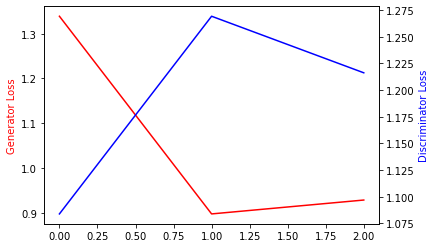

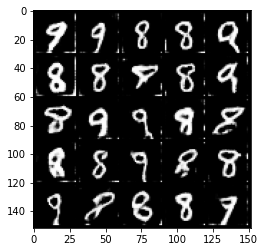

In [15]:
gen_loss, dis_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, criterion, batch_size, z_dim, epochs)

In [16]:
noise = torch.randn((1,z_dim),device = device)

In [17]:
def test_model(generator,output):
    label = torch.LongTensor([output]).to(device)
    image = generator(noise,label).cpu().detach()
    plt.imshow(image.squeeze(),cmap='gray')

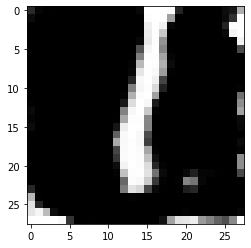

In [18]:
#generating 1
test_model(generator, 1)

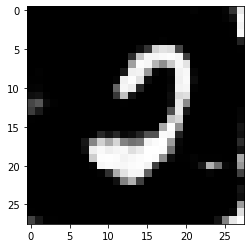

In [19]:
#generating 2
test_model(generator, 2)

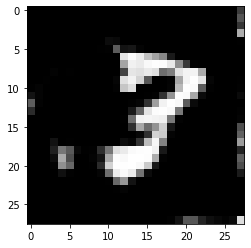

In [20]:
#generating 3
test_model(generator, 3)

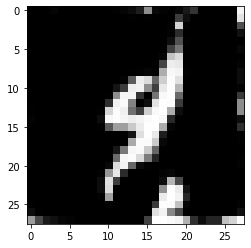

In [21]:
#generating 4
test_model(generator, 4)

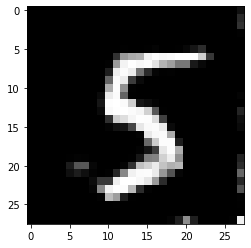

In [22]:
#generating 5
test_model(generator, 5)

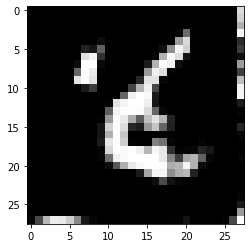

In [23]:
#generating 6
test_model(generator, 6)

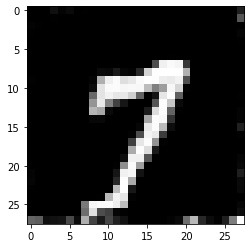

In [24]:
#generating 7
test_model(generator, 7)

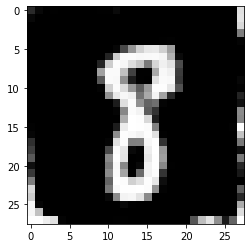

In [25]:
#generating 8
test_model(generator, 8)

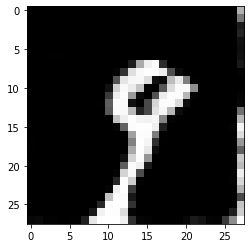

In [26]:
#generating 9
test_model(generator, 9)